# Task

Exploratory Data Analysis of Polish Twitter [dataset](http://2019.poleval.pl/index.php/tasks/task6)

# Init

## Importing modules

In [47]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

## Constants

In [55]:
DATA_DIR = 'data/'
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'train/')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'test/')

MAX_TWEET_LENGTH = 280

LABEL_NON_HARMFUL = 0
LABEL_HARMFUL = 1


## Helper functions 

In [10]:
def display_full_df(df) -> None:
    """Displays a df with no fixed width and a specified number of rows."""
    
    pd.set_option('display.max_columns', None)  # or 1000
    pd.set_option('display.max_rows', None)  # or 1000
    pd.set_option('display.max_colwidth', None)  # or 199
    print(df)


# Analysis

## Loading data

In [12]:
os.listdir(TRAIN_DATA_DIR)

['training_set_clean_only_tags.txt', 'training_set_clean_only_text.txt']

In [13]:
TRAIN_DATA = os.path.join(TRAIN_DATA_DIR, os.listdir(TRAIN_DATA_DIR)[1])
TRAIN_LABELS = os.path.join(TRAIN_DATA_DIR, os.listdir(TRAIN_DATA_DIR)[0])

In [14]:
data_df = pd.read_csv(TRAIN_DATA, sep='\n', names=['text'])
labels_df = pd.read_csv(TRAIN_LABELS, sep='\n', names=['label'])

data_df.shape, labels_df.shape

((10041, 1), (10041, 1))

In [15]:
data_df.head()

,text
0,Dla mnie faworytem do tytułu będzie Cracovia. ...
1,@anonymized_account @anonymized_account Brawo ...
2,"@anonymized_account @anonymized_account Super,..."
3,@anonymized_account @anonymized_account Musi. ...
4,"Odrzut natychmiastowy, kwaśna mina, mam problem"


In [16]:
labels_df.head()

,label
0,0
1,0
2,0
3,0
4,0


Concatenating dataframes

In [17]:
df = pd.concat([data_df, labels_df], axis=1)

df.head()

,text,label
0,Dla mnie faworytem do tytułu będzie Cracovia. ...,0
1,@anonymized_account @anonymized_account Brawo ...,0
2,"@anonymized_account @anonymized_account Super,...",0
3,@anonymized_account @anonymized_account Musi. ...,0
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0


## EDA

### Null values

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10041 entries, 0 to 10040
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10041 non-null  object
 1   label   10041 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 157.0+ KB


In [20]:
df.isnull().sum()

text     0
label    0
dtype: int64

No null values

### Labels

In [21]:
df['label'].unique()

array([0, 1])

No incorrect labels

### Distribution of labels

In [22]:
df['label'].value_counts()

0    9190
1     851
Name: label, dtype: int64

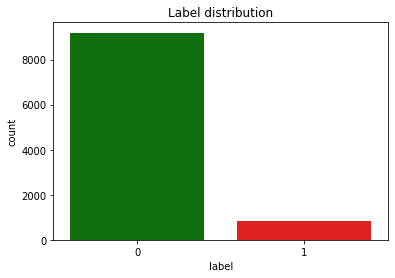

In [58]:
# Customization
hue_colors = {LABEL_NON_HARMFUL: 'green',
              LABEL_HARMFUL: 'red'}

plt.xticks(range(2), ['Positive [0]', 'Negative [1]'])
plt.title('Label distribution')

sns.countplot(x='label', data=df, palette=hue_colors)

plt.show()

Unfortunately the labels are not equally distributed. This may be a significant problem and has to be considered in evaluation metrics.

### Length of tweets

In [29]:
df['text'].str.len()

0         78
1         82
2        125
3         67
4         47
        ... 
10036     48
10037    149
10038     81
10039    132
10040     56
Name: text, Length: 10041, dtype: int64

In [44]:
print(f'Average tweet length: {int(np.mean(df["text"].str.len()))}')
print(f'Median tweet length: {int(np.median(df["text"].str.len()))}')

Average tweet length: 93
Median tweet length: 91


### Most frequent words

In [11]:
# display_full_df(df)

## Bag-of-Words

In [12]:
count_vectorizer = CountVectorizer()

In [13]:
cv_transformed = count_vectorizer.fit_transform(df['text']).toarray()
count_vectorizer.get_feature_names()[1000:1020]

['biedak',
 'biedaku',
 'biedna',
 'biedne',
 'biednego',
 'biedni',
 'biedniejsze',
 'biedniejszych',
 'biedny',
 'biedronce',
 'biedronka',
 'biedronki',
 'biedroń',
 'biedy',
 'biedę',
 'bieg',
 'biega',
 'biegali',
 'biegam',
 'biegania']

In [14]:
df_cv = pd.DataFrame(cv_transformed, columns=count_vectorizer.get_feature_names())

In [15]:
df_cv.head()

,00,01,02s91ipder,03,04,06,0888888888,0jdgav1mow,0q4pyaqhlz,0sxlbtcpgh,...,żądza,żądło,żłobu,лайка,איזה,הנשיא,מצוין,פולני,רעיון,של
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
df_cv.sum(axis=0)

00            25
01             5
02s91ipder     1
03             1
04             1
              ..
הנשיא          2
מצוין          2
פולני          2
רעיון          2
של             2
Length: 22872, dtype: int64

Analysis:
- https://towardsdatascience.com/sentiment-analysis-concept-analysis-and-applications-6c94d6f58c17
- https://towardsdatascience.com/preprocessing-text-data-using-python-576206753c28
- https://towardsdatascience.com/nlp-part-3-exploratory-data-analysis-of-text-data-1caa8ab3f79d
- https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
- https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/

- Perform simple analysis:
    - Word count
    - Most frequent words
    - Length of tweets
    - Average tweet length by class
    - Average word length by class
- Remove emoji's? Or maybe tokenize them
    - https://github.com/huggingface/transformers/issues/7648
    - https://stackoverflow.com/questions/57679668/tokenizing-emojis-contiguous-to-words

- Check if tagging other account by `@anonymized_account`, is correlated with the labels
- Check if retweeting `RT`, is correlated with the labels


Preprocessing:
- Lower the text? (not always as capital text is 'shouting') - check if more uppercase means cyberbullying
- Remove duplicates (181 i 182 - duplikaty)
- Create a pipeline!!!